In [1]:
from fastai.vision.all import *
import fastai
from PIL import Image
import pandas as pd

In [2]:
path = untar_data(URLs.IMAGENETTE_320,archive = '/FastAi_Data/')

In [3]:
path.ls()

(#3) [Path('C:/Users/adima/.fastai/data/imagenette2-320/noisy_imagenette.csv'),Path('C:/Users/adima/.fastai/data/imagenette2-320/train'),Path('C:/Users/adima/.fastai/data/imagenette2-320/val')]

In [4]:
noisy_csv = path/'noisy_imagenette.csv'

In [5]:
ds = pd.read_csv(noisy_csv)
ds.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False


In [6]:
ds.describe()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
count,13394,13394,13394,13394,13394,13394,13394
unique,13394,10,10,10,10,10,2
top,train/n02979186/n02979186_9036.JPEG,n02979186,n01440764,n03445777,n03888257,n03394916,False
freq,1,1350,1358,1366,1409,1390,9469


In [7]:
ds[ds['is_valid']==True][:5]

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
9469,val/n02979186/n02979186_8971.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,True
9470,val/n02979186/n02979186_14550.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,True
9471,val/n02979186/n02979186_11971.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,True
9472,val/n02979186/n02979186_11550.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,True
9473,val/n02979186/n02979186_8751.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,True


From what I understand, If is_valid is True then it is a validation set. 

In [8]:
ds.path[0]

'train/n02979186/n02979186_9036.JPEG'

In [9]:
img_path = path/ds.path[0]

In [10]:
im = Image.open(img_path)

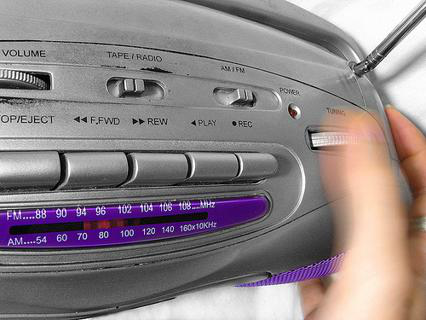

In [11]:
im

In [12]:
ds['is_valid'][9469]

True

In [13]:
def splitter(ds):
    train = ds.index[~ds.is_valid].to_list()
    valid = ds.index[ds.is_valid].to_list()
    return train,valid

In [14]:
def get_x(r):
    return path/r['path']

In [15]:
## Creating a DataBlock
def get_dls(size, path, bs, noise_val=5):
    assert noise_val in [0,5,25,50], '`pct_noise` must be 0,5,25 or 50.'
    
    ds = pd.read_csv(path/'noisy_imagenette.csv')
    
    dblock = DataBlock(
        blocks = (ImageBlock,CategoryBlock),
        get_x = get_x,
        get_y = ColReader(f'noisy_labels_{noise_val}'),
        splitter = splitter,
        item_tfms= [RandomResizedCrop(size,min_scale=0.35),FlipItem(0.5)],
        batch_tfms= [Normalize.from_stats(*imagenet_stats)]
        )
    
    return dblock.dataloaders(ds, bs = bs)

In [16]:
dls = get_dls(224, path, bs=64, noise_val=50)

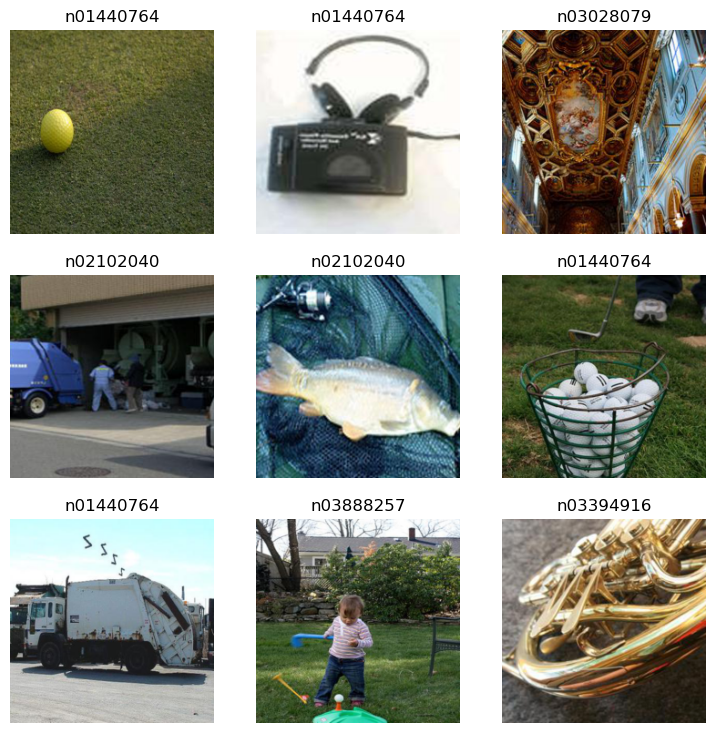

In [17]:
dls.show_batch()

In [18]:
model = xse_resnext18(n_out = dls.c)
learn = Learner(dls, model, opt_func=Adam,
                metrics=accuracy, loss_func= LabelSmoothingCrossEntropy())

In [20]:
learn.fit_flat_cos(80,  lr = 1e-2, cbs=MixUp)

epoch,train_loss,valid_loss,accuracy,time
0,2.325489,2.234063,0.223949,02:47
1,2.281184,2.206927,0.208153,02:43
2,2.268001,2.136496,0.294522,02:48
3,2.263768,2.173308,0.251720,02:42
4,2.253430,2.094940,0.300637,02:39
5,2.233322,1.990510,0.430573,02:39
6,2.223813,1.943183,0.441019,02:39
7,2.205799,1.899905,0.497834,02:39
8,2.198026,1.837529,0.516943,02:39
9,2.194574,1.871040,0.484586,02:39


In [45]:
dls.c

10